# Introduction to Latent Dirichlet Allocation
In this notebook you will
- Train an LDA model on the reading_600 dataset
- Use the model to investigate the topics present
- Test the model on a held-out test set to see how well the LDA topics align with the domains in the dataset

## Load the dataset

In [ ]:
# My colab was having a problem with pandas and numpy

#!pip install --upgrade --force-reinstall pandas numpy
#!pip install --upgrade pandas numpy

!pip install numpy==1.23.5
!pip install pandas==1.5.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 50.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires numpy>=1.24.2, but you have numpy 1.23.5 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.1 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 72.0 MB/s eta 0:00:00
^C


In [ ]:
!pip install pyLDAvis  --quiet # For visualization
from google.colab import drive
import numpy as np
import pandas as pd

# for machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import (  # Metrics
    accuracy_score,
    precision_score,
    recall_score,
    adjusted_rand_score,
)

# All the gensim stuf
from gensim.parsing.preprocessing import (  # Preprocessing tools from topic modeling library
    preprocess_string,
    strip_punctuation,
    strip_multiple_whitespaces,
    strip_numeric,
    remove_stopwords,
)
from gensim.corpora import Dictionary
from gensim.models import LdaModel  # The LDA model
from gensim.models import CoherenceModel  # For coherence

import matplotlib.pyplot as plt  # For viz
import pyLDAvis.gensim

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
# Below will prompt for authorization
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv(
    "/content/drive/MyDrive/Colab_Notebooks/DS_5780_spring_25/data/reading_2019/reading_600_texts.csv",
    #"/content/drive/MyDrive/Colab_Notebooks/DS_5780_spring_25/data/writing_long/writing_data_w_meta_data.csv",
    encoding='ISO-8859-1'
    )

# We always want to look at the information about the dataset as a sanity check.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              591 non-null    int64  
 1   text            591 non-null    object 
 2   bt_readability  591 non-null    float64
 3   Source          588 non-null    object 
 4   Topic           591 non-null    object 
 5   Text type       591 non-null    object 
 6   Domain          591 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 32.4+ KB


Let's take a look at the domains present in the dataset.

It looks like these are essays about science, technology, and history.

In [ ]:
df['Domain'].value_counts()

,count
Domain,
History,199
Science,197
Technology,195


In [ ]:
# What about the text
df['text'][0]

"The Solar System is the Sun and all the objects in orbit around it. The Sun is orbited by planets, asteroids, comets and other things.\n\nThe Sun is a star. It contains 99.9 percent of the Solar System's mass. This means that it has strong gravity. The other objects are pulled into orbit around the Sun. The sun is mostly made out of hydrogen and helium.\n\nThere are eight planets in the Solar System. From closest to farthest from the Sun, they are: Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus and Neptune. The first four planets are called terrestrial planets. They are mostly made of rock and metal, and they are mostly solid. The last four planets are called gas giants. This is because they are large planets that are mostly made of gas. Even though they are made of gas, they have much more mass than the terrestrial planets.\n\n"

In [ ]:
# Lowercase the text column to reduce the number of words in the vocabulary
df['text'] = df['text'].str.lower()

df['text'][0]

"the solar system is the sun and all the objects in orbit around it. the sun is orbited by planets, asteroids, comets and other things.\n\nthe sun is a star. it contains 99.9 percent of the solar system's mass. this means that it has strong gravity. the other objects are pulled into orbit around the sun. the sun is mostly made out of hydrogen and helium.\n\nthere are eight planets in the solar system. from closest to farthest from the sun, they are: mercury, venus, earth, mars, jupiter, saturn, uranus and neptune. the first four planets are called terrestrial planets. they are mostly made of rock and metal, and they are mostly solid. the last four planets are called gas giants. this is because they are large planets that are mostly made of gas. even though they are made of gas, they have much more mass than the terrestrial planets.\n\n"

## Split the dataset
We will use a 80/20 train test split.

Using sklearn train_test_split

In [ ]:
train, test = train_test_split(df, test_size = 0.2, random_state=42)

# random state to get same split every time

In [ ]:
len(test)  # 119 in test set

119

## Preprocess the dataset
Gensim's `preprocess_string()` function applies a list of filters to a given string. You can modify the filters used, but by default these filters are:
- `strip_tags(): Any html markup
- `strip_punctuation()`
- `strip_multiple_whitespaces()`
- `strip_numeric()`
- `remove_stopwords()`
- `strip_short(): Short words
- `stem_text(): Stem the text

For our use case, we will not use the default filters.

Why?
  - strip_short removes words that are fewer than three characters
  - stem_text is weird...
  - we do not have any html tags

In [ ]:
# Define a custom list of filters, excluding stem_text()
filter = [strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords]

# Now use the custom filters when preprocessing
train_tokenized = [preprocess_string(doc, filter) for doc in train['text']]
test_tokenized = [preprocess_string(doc, filter) for doc in test['text']]

In [ ]:
print(train_tokenized[0:1])

[['random', 'access', 'memory', 'simply', 'ram', 'memory', 'information', 'storage', 'store', 'running', 'programs', 'data', 'programs', 'data', 'information', 'ram', 'read', 'written', 'quickly', 'order', 'normally', 'random', 'access', 'memory', 'form', 'chips', 'usually', 'contents', 'ram', 'accessible', 'faster', 'types', 'information', 'storage', 'lost', 'time', 'turned', 'non', 'volatile', 'random', 'access', 'memory', 'nvram', 'keeps', 'data', 'power', 'expensive', 'works', 'slowly', 'smaller', 'amounts', 'late', 'th', 'century', 'ram', 'uses', 'transistors', 'usually', 'mosfets', 'store', 'data']]


## Generate dictionaries
- You can use a **Bag of Words** corpus

OR

- a **TF-IDF** corpus to train an LDA model

      We will start with using a BoW corpus.

In [ ]:
gensim_dictionary = Dictionary()  # Import dictionary for mapping
bow_corpus = [gensim_dictionary.doc2bow(doc, allow_update=True) for doc in train_tokenized]
# Converts document to tuples with (word_id, word_count)
id_words = [[(gensim_dictionary[id], count) for id, count in line] for line in bow_corpus]
# Converts the numerical word IDs back to their original word forms with a tuple for (word, count)

print(bow_corpus[0])
print(id_words[0])


# This is how you would train a tf-idf model
# tfidf = TfidfModel(bow_corpus)
# tfidf_corpus = tfidf[bow_corpus]

[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 4), (7, 1), (8, 1), (9, 1), (10, 3), (11, 1), (12, 1), (13, 1), (14, 4), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 4), (24, 3), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1)]
[('access', 3), ('accessible', 1), ('amounts', 1), ('century', 1), ('chips', 1), ('contents', 1), ('data', 4), ('expensive', 1), ('faster', 1), ('form', 1), ('information', 3), ('keeps', 1), ('late', 1), ('lost', 1), ('memory', 4), ('mosfets', 1), ('non', 1), ('normally', 1), ('nvram', 1), ('order', 1), ('power', 1), ('programs', 2), ('quickly', 1), ('ram', 4), ('random', 3), ('read', 1), ('running', 1), ('simply', 1), ('slowly', 1), ('smaller', 1), ('storage', 2), ('store', 2), ('th', 1), ('time', 1), ('transistors', 1), ('turned', 1), ('types', 1), ('uses', 1), ('usually', 2), ('volatile', 1), ('works', 1), ('written', 1)

## Determine optimal number of topics
- We will generate eight models, and check the coherence against the training corpus.
- We will use coherence scores to measure topic interpretability.
 - High coherence means the words in a topic are closely related and form a meaningful concept.
 - Low coherence suggests that the words in a topic are not strongly related, making the topic less interpretable.
- Typically, you want to choose the minimum number of topics where the coherence score begins to plateau.
- In our case, however, we are hoping to check how well the topics generated from the text map to the topic domains from the corpus
  - we have theoretical reasons to select three topics.
  - but we still want to check

Num Topics: 2, Coherence Score: 0.2692170938628293
Num Topics: 3, Coherence Score: 0.24452642703547514
Num Topics: 4, Coherence Score: 0.31495036435011814
Num Topics: 5, Coherence Score: 0.26449884711085797
Num Topics: 6, Coherence Score: 0.3015059135425301
Num Topics: 7, Coherence Score: 0.3186066410509407
Num Topics: 8, Coherence Score: 0.31262693723082574
Num Topics: 9, Coherence Score: 0.33793926042250666


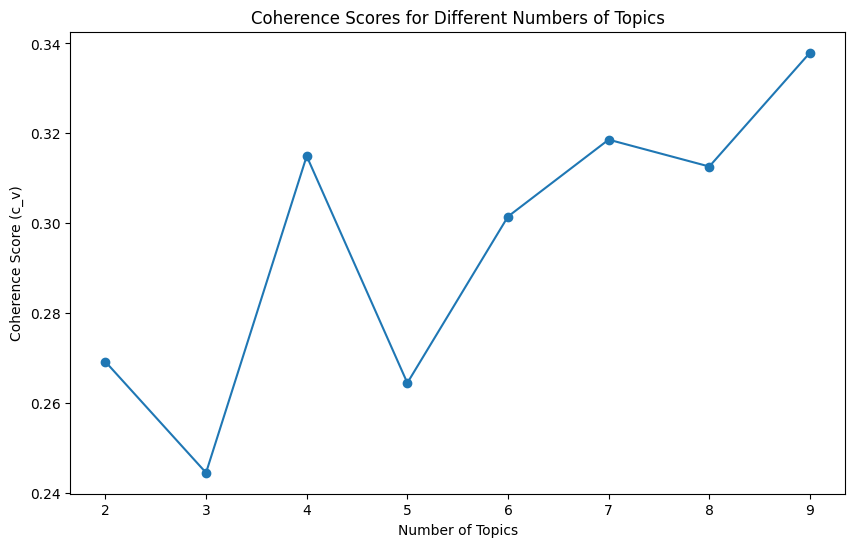

In [ ]:
# Train LDA models and compute coherence scores
coherence_scores = []
topic_nums = range(2, 10, 1)  # Test topic numbers from 2 to 9 in steps of 1

for num_topics in topic_nums:
    # Train LDA model
    lda_model = LdaModel(corpus=bow_corpus,  # Our corpus from earlier
                         id2word=gensim_dictionary,  # Mapping for ids and words
                         num_topics=num_topics,  # Current value
                         random_state=42,  # Reproducibility
                         passes=20)  # Number of iterations over corpus in training
                         # Larger datasets likely need fewer passes. 10-20 generally sufficient

    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model,  # Our model
                                     texts=train_tokenized,  # Our data
                                     dictionary=gensim_dictionary,  # Our dictionary
                                     coherence='c_v')  # c_v for balance between interpretability and efficiency

    coherence_score = coherence_model.get_coherence()  # Calculate coherence score
    coherence_scores.append(coherence_score)  # Append it
    print(f"Num Topics: {num_topics}, Coherence Score: {coherence_score}")
    # Print number of topics and matching coherence score

# THIS WILL TAKE AWHILE TO RUN...

# Step 3: Plot coherence scores
plt.figure(figsize=(10, 6))  # Size of plot by inches
plt.plot(topic_nums, coherence_scores, marker='o')  # Number by coherence using circles
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence Scores for Different Numbers of Topics")
plt.show()

## Build the model
It looks like 9 topics are the best.

That's not what we wanted...
  - But three topics is pretty strong!

And, we have theoretical reasons to choose three topics for our model.

  - We want to try to see how well the topics generated from the text map onto the domains from the corpus.
  - So, let's see what happens with three topics
    - We can look at nine topics later

**Do Not Worry**
- We will return to 6 topics!


In [ ]:
lda_model_3topics = LdaModel(bow_corpus,
                    num_topics=3,
                    id2word = gensim_dictionary,
                    random_state=42,
                    passes = 20)

### Check out our model
First we will look at perplexity and coherence
- **Perplexity** is a metric used to evaluate the performance of a model, particularly in assessing how well the model generalizes to unseen data
 - Perplexity is a function of the likelihood of the data given the model.
 - Lower perplexity means the model should be better at predicting the test data, as it assigns higher probabilities to the observed words.
 - Higher perplexity indicates that the model is less confident or less accurate in predicting the data.
 - There is no fixed threshold for what constitutes a "good" perplexity score
  - Score depends on the specific dataset and problem domain


- **Coherence** is a metric used to evaluate the quality and interpretability of the topics discovered by a model.
 - High coherence means the words in a topic are closely related and form a meaningful concept.
 - Low coherence suggests that the words in a topic are not strongly related, making the topic less interpretable.
 - Think of coherence a bit like semantic similarity scores
  - .30 likely means a decent relationship


- We can interpret the model by looking at each topic's **key words**.
 - Here are the key words for each topic that the LDA model predicted.
 - The weights are how important the word is to the topic.
 - Can you make any inferences about what each topic might be about?

In [ ]:
# From gensim.models import CoherenceModel
import pprint as pp #pretty printing for lists and dictionaries

print('\n\n')

# Compute Perplexity
print(f"PERPLEXITY: {lda_model_3topics.log_perplexity(bow_corpus)}")
# Log instead of raw because easier to vizualize

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_3topics, texts=train_tokenized, dictionary=gensim_dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"COHERENCE: {coherence_lda}")

# Show topic keywords
print('\nKEYWORDS that hopefully match to history, science, and technology!')
pp.pprint(lda_model_3topics.print_topics(num_words=20))

# Remember, our three topics are
# History
# Science
# Technology




PERPLEXITY: -8.492508113780504
COHERENCE: 0.32729976850351333

KEYWORDS that hopefully match to history, science, and technology!
[(0,
  '0.007*"s" + 0.006*"water" + 0.006*"called" + 0.006*"earth" + 0.005*"energy" '
  '+ 0.004*"light" + 0.003*"use" + 0.003*"known" + 0.003*"different" + '
  '0.003*"information" + 0.003*"data" + 0.003*"waves" + 0.002*"solar" + '
  '0.002*"like" + 0.002*"usually" + 0.002*"time" + 0.002*"electricity" + '
  '0.002*"electrons" + 0.002*"people" + 0.002*"form"'),
 (1,
  '0.008*"people" + 0.006*"war" + 0.006*"states" + 0.006*"s" + 0.004*"united" '
  '+ 0.004*"world" + 0.004*"countries" + 0.003*"government" + 0.003*"known" + '
  '0.003*"power" + 0.003*"called" + 0.003*"age" + 0.003*"europe" + '
  '0.003*"year" + 0.003*"great" + 0.003*"way" + 0.003*"political" + '
  '0.002*"time" + 0.002*"american" + 0.002*"country"'),
 (2,
  '0.006*"energy" + 0.005*"software" + 0.005*"use" + 0.004*"like" + '
  '0.003*"different" + 0.003*"called" + 0.003*"devices" + 0.003*"usu

### Interpretation

This does not look bad.

Topic 0 = Science

Topic 1 = History

Topic 2 = Technology

The coherence score (.322) is okay...
  - Think coherence values in Word2Vec

### Let's visualize it!
`pyLDAvis` is a package that lets you visualize LDA models.
- On the left you can see how well our three topics seperate in two principal component dimensions.
- On the right you can see the terms in the corpus.
 - The blue lines represent total term frequency in the corpus.
 - The red lines show estimated term frequency in the topic.

 The topic numbers may differ...

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(topic_model=lda_model_3topics,
                        corpus=bow_corpus,
                        dictionary=gensim_dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.091886 -0.069838       1        1  41.644857
1     -0.125584 -0.025512       2        1  32.123746
2      0.033698  0.095350       3        1  26.231398, topic_info=          Term        Freq       Total Category  logprob  loglift
1040     water  103.000000  103.000000  Default  30.0000  30.0000
948   software   59.000000   59.000000  Default  29.0000  29.0000
547        war   92.000000   92.000000  Default  28.0000  28.0000
61       earth  100.000000  100.000000  Default  27.0000  27.0000
543     states   88.000000   88.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
131       high   17.388479   49.382497   Topic3  -6.3528   0.2944
20       power   18.637798   82.999716   Topic3  -6.2834  -0.1554
443     people   20.790001  155.768990   Topic3  -6.1741  -0.6757
80       known   18.611406  109.814636   Topic3  -6.2848  -0.4368
253    example   17.353655   62.558685   Topic3  -6.3548   0.0559

[242 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1322      1  0.898306    acids
1696      1  0.062057  african
1696      2  0.930858  african
159       1  0.070480      age
159       2  0.822272      age
...     ...       ...      ...
795       2  0.896647     year
795       3  0.026372     year
110       1  0.323164    years
110       2  0.513260    years
110       3  0.152077    years

[387 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

Definitely seems to be picking up on the topics

## Testing
- Let's test our model by comparing it to the domains.
- We will use the `LdaModel().get_document_topics()` method to get topics from new texts.
- We set minimum probability to 0 because we want to get a tuple with length = 3 for each item.


In [ ]:
# Remember, we have already tokenized the test set above.

# Get bag of words representations of the tokenized test set using  gensim_dictionary from previous
test_corpus = [gensim_dictionary.doc2bow(text) for text in test_tokenized]
# Get predicted topic distribution for each documents in test set using trained LDA model
preds = lda_model_3topics.get_document_topics(test_corpus,
                                              minimum_probability = 0,  # Ensure all topics included
                                              per_word_topics = False)  # Only document level distribution

# We get our predicted topics by getting the max score across the three.
predicted_topics = [np.argmax(np.array([score[1] for score in doc])) for doc in preds]

# [score[1] for score in doc] = extract probability score for each topic
# np.argmax = find and assign topic to text

# Predicted_topics # what are the predicted topics
# len(predicted_topics) # there are 60 of them.



# Set the dataframe 'preds' column for the predicted topics.
test['lda_bow_preds'] = predicted_topics
test[['Domain','lda_bow_preds']].head()  # Show domain and prediction columns in test set

,Domain,lda_bow_preds
505,History,0
586,History,1
195,History,1
165,Technology,0
453,History,1


Now, let's add the actual topic scores to the test dataframe just in case we want to use it at some other point

  - Correlate with readability score
  - Separate simple from authentic

In [ ]:
# Create a df with predicted topic distributions
topic_scores = pd.DataFrame([[score[1] for score in doc] for doc in preds],  # Grab up scores
                               columns=[f'Topic_{i}' for i in range(3)],  # Create column names
                               index=test.index)  # Set index to test corpus for later merging


topic_scores


,Topic_0,Topic_1,Topic_2
505,0.619879,0.367129,0.012992
586,0.244226,0.741984,0.013790
195,0.149250,0.713164,0.137586
165,0.846114,0.080617,0.073269
453,0.006863,0.792196,0.200941
...,...,...,...
473,0.009790,0.565927,0.424282
234,0.127957,0.357510,0.514533
300,0.849160,0.128878,0.021962
212,0.174557,0.400869,0.424574


In [ ]:
# Make sure they are the same lengths
print(len(topic_scores))  # 119 x 3
print(len(test))  # 119 x 9

final_test_topic_pred= pd.concat([test, topic_scores], axis=1)



119
119


In [ ]:
final_test_topic_pred

,id,text,bt_readability,Source,Topic,Text type,Domain,lda_bow_preds,Topic_0,Topic_1,Topic_2
505,513,monotheism has been defined as the belief in t...,0.048035,https://en.wikipedia.org/wiki/Monotheism,monotheism,Regular,History,0,0.619879,0.367129,0.012992
586,596,historiography is the study of the methodology...,0.181519,https://en.wikipedia.org/wiki/Historiography,Historiography,Regular,History,1,0.244226,0.741984,0.013790
195,198,a boycott is a protest where the protesters do...,0.080899,https://simple.wikipedia.org/wiki/Boycott,boycott,Simple,History,1,0.149250,0.713164,0.137586
165,167,air navigation is navigation while flying. it ...,0.088027,https://simple.wikipedia.org/wiki/Air_navigation,air navigation,Simple,Technology,0,0.846114,0.080617,0.073269
453,461,diarchy (or dyarchy; from the greek î´î¹- / î´...,0.235969,https://en.wikipedia.org/wiki/Diarchy,diarchy,Regular,History,1,0.006863,0.792196,0.200941
...,...,...,...,...,...,...,...,...,...,...,...
473,481,"the miranda warning, which can also be referre...",0.084432,https://en.wikipedia.org/wiki/Miranda_warning,miranda warning,Regular,History,1,0.009790,0.565927,0.424282
234,237,the rosetta stone is a stone with writing carv...,0.024083,https://simple.wikipedia.org/wiki/Rosetta_Stone,rosetta stone,Simple,History,2,0.127957,0.357510,0.514533
300,305,mercury is the smallest and innermost planet i...,0.178654,https://en.wikipedia.org/wiki/Mercury_(planet),mercury,Regular,Science,0,0.849160,0.128878,0.021962
212,215,urbanization (or urbanisation) is a term from ...,0.060955,https://simple.wikipedia.org/wiki/Urbanization,urbanization,Simple,History,2,0.174557,0.400869,0.424574


### Assign values to domain to match predictions

Give domain names numeric values

Then we can calculate
- accuracy
      - proportion of correctly classified instances out of the total number of instances
- recall
      - proportion of correctly predicted positive instances out of all actual positive instances
- precision
      - proportion of correctly predicted positive instances out of all instances predicted as positive


In [ ]:
test['domain_Numeric'] = test['Domain'].map({'History': 1, 'Science': 0, 'Technology': 2})
test.head()
print(test.dtypes)

id                  int64
text               object
bt_readability    float64
Source             object
Topic              object
Text type          object
Domain             object
lda_bow_preds       int64
domain_Numeric      int64
dtype: object


## Classification Metrics Average Strategy

In scikit-learn, when calculating metrics for multi-class or multi-label classification, the average parameter in functions like f1_score and precision_score determines how scores are averaged across classes: `micro` considers each element as a label, `macro` calculates the unweighted mean of each class's score, and `weighted` calculates the mean weighted by the support of each class.

If the class labels are perfectly balanced, then `micro` and `macro` are the same. If there is a class which occurs less frequently but is equally important as the rest, then macro-average is the preferred metric.

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(test['lda_bow_preds'], test['domain_Numeric'])

# Calculate precision (macro-averaged)
precision = precision_score(test['lda_bow_preds'], test['domain_Numeric'], average='macro')

# Calculate recall (macro-averaged)
recall = recall_score(test['lda_bow_preds'], test['domain_Numeric'], average='macro')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.6974789915966386
Precision: 0.6774151774151774
Recall: 0.7643264143264145


That's not bad...

### Adjusted Rand Index
- The Adjusted Rand Index (ARI) is a measure used to evaluate the similarity between two different clusterings or groupings of the same data, often used in machine learning to assess clustering performance.
- It ranges from -1 to 1, with 1 indicating perfect agreement, 0 representing no more agreement than would be expected by chance, and -1 indicating perfect disagreement.

In [ ]:
adjusted_rand_score(test['Domain'], test['lda_bow_preds'])

0.3447295784406358

Not bad...

# Now it's your turn!
- We chose three topics because that was how many topic domains were in the corpus.
  - But we saw that a nine topic solution had better coherence.
- Let's try it with nine topics!
- Then use `pyLDAvis` to visualize your new model and interpret the topics.
- Compare with our original model.
  - What changed?
  - What stayed the same?

- Can you assign values to the topics that match onto the original topics
  - History
  - Science
  - Technology

  And run precision, recall, and accuracy again?

  If really curious, use a TF-IDF approach.